In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')


from zipfile import ZipFile
 
data_path = 'lung_colon_image_set.zip'
 
with ZipFile(data_path,'r') as zip:
  zip.extractall()
  print('The data set has been extracted.')

In [2]:
path = 'lung_image_sets'
targets = os.listdir(path)
targets

['lung_aca', 'lung_n', 'lung_scc']

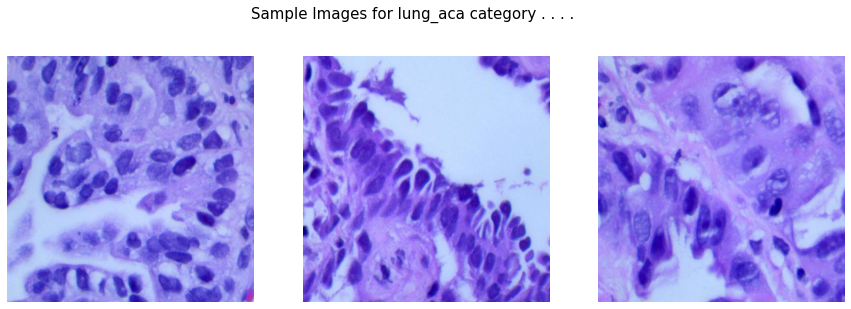

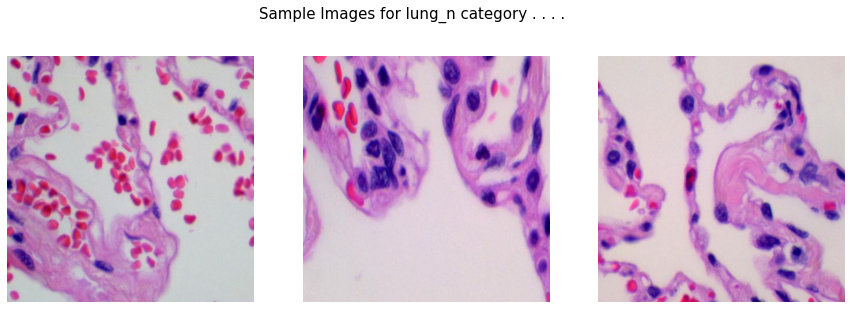

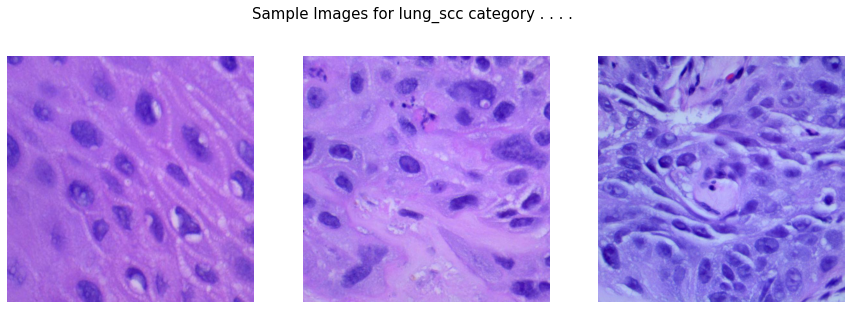

In [3]:
for categories in targets:
    image_dir = f'{path}/{categories}'
    images = os.listdir(image_dir)
 
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Sample Images for {categories} category . . . .', fontsize=15)
 
    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{categories}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [4]:
IMG_SIZE = 256
EPOCHS = 10
BATCH_SIZE = 64

In [5]:
X = []
Y = []

for i, categories in enumerate(targets):
    images = glob(f'{path}/{categories}/*.jpeg')

    for image in images:
        img = cv2.imread(image)
        X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
        Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values


In [6]:
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y, test_size = 0.2, random_state = 2022)
print(X_train.shape, X_val.shape)


(4800, 256, 256, 3) (1200, 256, 256, 3)


In [7]:
model = keras.models.Sequential([
	layers.Conv2D(filters=32,
				kernel_size=(5, 5),
				activation='relu',
				input_shape=(IMG_SIZE,
							IMG_SIZE,
							3),
				padding='same'),
	layers.MaxPooling2D(2, 2),

	layers.Conv2D(filters=64,
				kernel_size=(3, 3),
				activation='relu',
				padding='same'),
	layers.MaxPooling2D(2, 2),

	layers.Conv2D(filters=128,
				kernel_size=(3, 3),
				activation='relu',
				padding='same'),
	layers.MaxPooling2D(2, 2),

	layers.Flatten(),
	layers.Dense(256, activation='relu'),
	layers.BatchNormalization(),
	layers.Dense(128, activation='relu'),
	layers.Dropout(0.3),
	layers.BatchNormalization(),
	layers.Dense(3, activation='softmax')
])


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 128)      0

In [9]:
model.compile(
	optimizer = 'adam',
	loss = 'categorical_crossentropy',
	metrics = ['accuracy']
)


from keras.callbacks import EarlyStopping, ReduceLROnPlateau


class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if logs.get('val_accuracy') > 0.90:
			print('\n Validation accuracy has reached upto \
					90% so, stopping further training.')
			self.model.stop_training = True


es = EarlyStopping(patience=3,
				monitor='val_accuracy',
				restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss',
					patience=2,
					factor=0.5,
					verbose=1)


In [10]:
history = model.fit(X_train, Y_train,
					validation_data = (X_val, Y_val),
					batch_size = BATCH_SIZE,
					epochs = EPOCHS,
					verbose = 1)


Epoch 1/10
75/75 [==============================] - 297s 4s/step - loss: 0.4689 - accuracy: 0.8006 - val_loss: 23.0792 - val_accuracy: 0.3300
Epoch 2/10
75/75 [==============================] - 277s 4s/step - loss: 0.3018 - accuracy: 0.8817 - val_loss: 2.7203 - val_accuracy: 0.4100
Epoch 3/10
75/75 [==============================] - 282s 4s/step - loss: 0.2289 - accuracy: 0.9062 - val_loss: 11.1608 - val_accuracy: 0.5600
Epoch 4/10
75/75 [==============================] - 284s 4s/step - loss: 0.2051 - accuracy: 0.9171 - val_loss: 1.5711 - val_accuracy: 0.6417
Epoch 5/10
75/75 [==============================] - 289s 4s/step - loss: 0.1632 - accuracy: 0.9394 - val_loss: 1.5265 - val_accuracy: 0.4967
Epoch 6/10
75/75 [==============================] - 291s 4s/step - loss: 0.1357 - accuracy: 0.9525 - val_loss: 9.8979 - val_accuracy: 0.4558
Epoch 7/10
75/75 [==============================] - 300s 4s/step - loss: 0.1012 - accuracy: 0.9656 - val_loss: 5.0693 - val_accuracy: 0.3725
Epoch 8/10


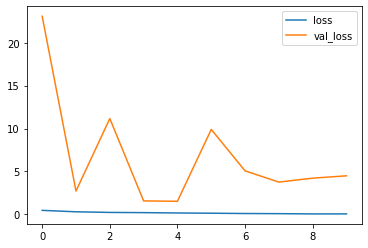

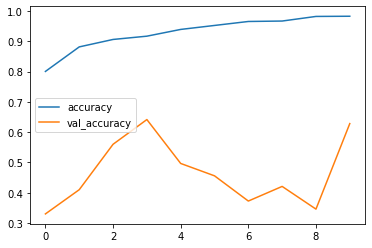

In [11]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

In [12]:
Y_pred = model.predict(X_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)

In [13]:
metrics.confusion_matrix(Y_val, Y_pred)


array([[  0, 296, 121],
       [  0, 396,   0],
       [  0,  29, 358]], dtype=int64)

In [14]:
print(metrics.classification_report(Y_val, Y_pred,
									target_names=targets))


              precision    recall  f1-score   support

    lung_aca       0.00      0.00      0.00       417
      lung_n       0.55      1.00      0.71       396
    lung_scc       0.75      0.93      0.83       387

    accuracy                           0.63      1200
   macro avg       0.43      0.64      0.51      1200
weighted avg       0.42      0.63      0.50      1200

